<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import tensorflow as tf

%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


### Task 2: Plot Sample Image

NotADirectoryError: [Errno 20] Not a directory: 'train/.DS_Store'

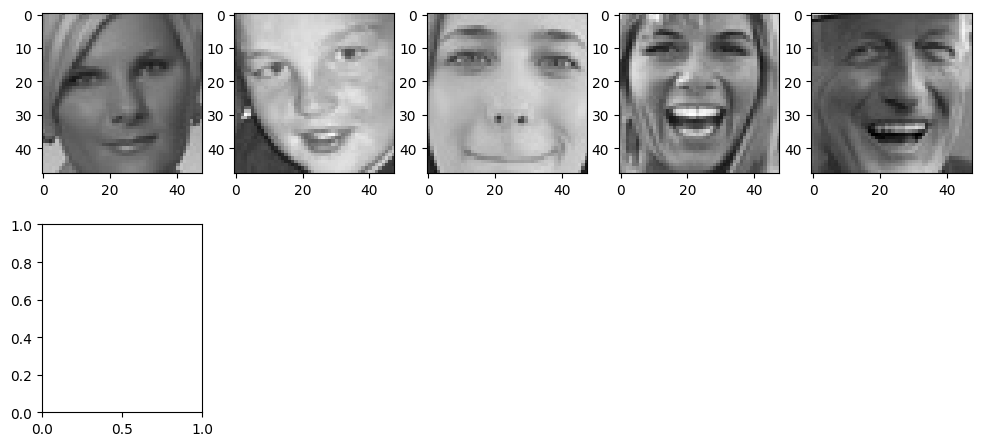

In [7]:
utils.datasets.fer.plot_example_images(plt).show()

In [ ]:
# Look at the plot and examine if there's an imbalance. 
# We must make sure that the number of happy images is balanced with the sad images

for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

3171 surprise images
7215 happy images
4965 neutral images
3995 angry images
4830 sad images
436 disgust images
4097 fear images


### Task 3: Generate Training and Validation Batches

In [ ]:
# Set parameters

img_size = 48 #By default, the images in FER2013 dataset is in 48x48
batch_size = 64

datagen_tr = ImageDataGenerator(horizontal_flip= True) #Randomly flips images along the horizontal axis
train_gen = datagen_tr.flow_from_directory("train/",
                                          target_size=(img_size, img_size),
                                          color_mode='grayscale',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=True)

datagen_ts = ImageDataGenerator(horizontal_flip= True) #Randomly flips images along the horizontal axis
test_gen = datagen_ts.flow_from_directory("test/",
                                          target_size=(img_size, img_size),
                                          color_mode='grayscale',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [ ]:
model = Sequential()

#conv1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1))) # 48 = size, 1=grayscale (3 if rgb)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

# conv2

model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

#conv 3
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

#conv 4
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

# flatten layers
model.add(Flatten())

# fully-connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005) #learning rate since it speeds up training, you can reduce to yor liking
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_13 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_14 (Batc (None, 24, 24, 128)      

### Task 6: Train and Evaluate Model

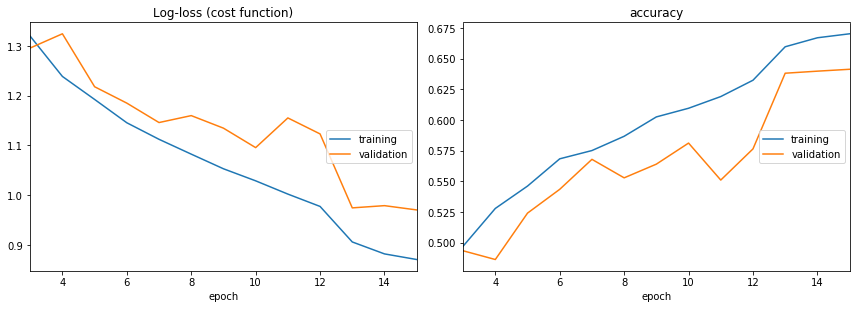

Log-loss (cost function):
training   (min:    0.871, max:    1.806, cur:    0.871)
validation (min:    0.970, max:    1.696, cur:    0.970)

accuracy:
training   (min:    0.307, max:    0.670, cur:    0.670)
validation (min:    0.355, max:    0.641, cur:    0.641)

Epoch 00015: saving model to model_weights.h5

448/448 [==============================] - 14s 31ms/step - loss: 0.8709 - accuracy: 0.6702 - val_loss: 0.9704 - val_accuracy: 0.6413


In [ ]:
epochs = 15
steps_per_epoch = train_gen.n//train_gen.batch_size
test_steps = test_gen.n//test_gen.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')

callbacks= [PlotLossesTensorFlowKeras(), checkpoint, reduce_lr]

history = model.fit(x = train_gen,
                   steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=test_gen,
                   validation_steps = test_steps,
                   callbacks=callbacks
                   )

# ACCURACY can be improved with longer training and epoch steps

### Task 7: Represent Model as JSON String

In [8]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

NameError: name 'model' is not defined